In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

from utils import get_fall_dataset, preprocess_df, print_rules, tree_to_rules

In [2]:
dataset = Path('WEDA-FALL/dataset/50Hz')

In [3]:
walking_dataset = dataset / 'D01'
walking_accel = (f for f in walking_dataset.glob('*_accel.csv') if 'vertical' not in f.name)
walking_gyro = walking_dataset.glob('*_gyro.csv')

In [4]:
jogging_dataset = dataset / 'D02'
jogging_accel = (f for f in jogging_dataset.glob('*_accel.csv') if 'vertical' not in f.name)
jogging_gyro = jogging_dataset.glob('*_gyro.csv')

In [5]:
df_list = []
for acc, gyro in zip(walking_accel, walking_gyro):
	df1 = pd.read_csv(acc)
	df2 = pd.read_csv(gyro)
	df = pd.concat([df1, df2], axis=1)
	df = preprocess_df(df).dropna()
	df['label'] = np.full(len(df), 'walking')
	df_list.append(df)
df_walking = pd.concat(df_list)

In [6]:
df_list = []
for acc, gyro in zip(jogging_accel, jogging_gyro):
	df1 = pd.read_csv(acc)
	df2 = pd.read_csv(gyro)
	df = pd.concat([df1, df2], axis=1)
	df = preprocess_df(df).dropna()
	df['label'] = np.full(len(df), 'jogging')
	df_list.append(df)
df_jogging = pd.concat(df_list)

In [7]:
df_fall = get_fall_dataset(dataset)
df_fall = df_fall[df_fall['label'] == 'fall']

df = pd.concat([df_walking, df_jogging, df_fall]).reset_index(drop=True)
# df = pd.concat([df_walking, df_jogging]).reset_index(drop=True)

In [8]:
df['label'].value_counts()

label
walking    61270
fall       43462
jogging    36897
Name: count, dtype: int64

In [9]:
X = df[['acceleration', 'rotationrate', 'angle_pitch']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size=0.2, random_state=42, shuffle=False
)

              precision    recall  f1-score   support

        fall       0.55      0.68      0.61     43462
     jogging       0.59      0.74      0.66     36897
     walking       0.94      0.64      0.76     61270

    accuracy                           0.68    141629
   macro avg       0.69      0.69      0.68    141629
weighted avg       0.73      0.68      0.69    141629



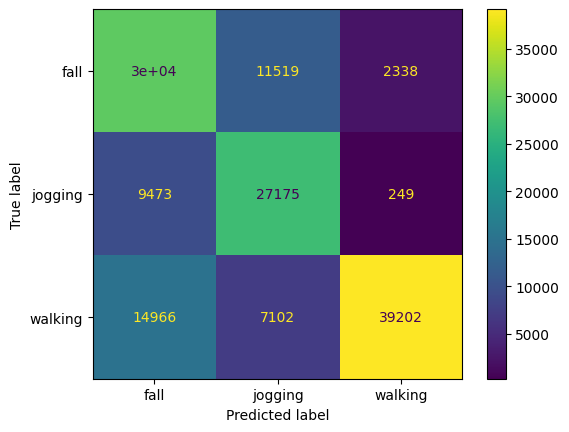

In [10]:
clf = DecisionTreeClassifier(random_state=42, max_depth=3, class_weight='balanced')
clf.fit(X_train, y_train)
cv = StratifiedKFold(n_splits=5, shuffle=False)
y_pred = cross_val_predict(clf, X, y, cv=cv, n_jobs=-1)

print(classification_report(y, y_pred))

cm = confusion_matrix(y, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

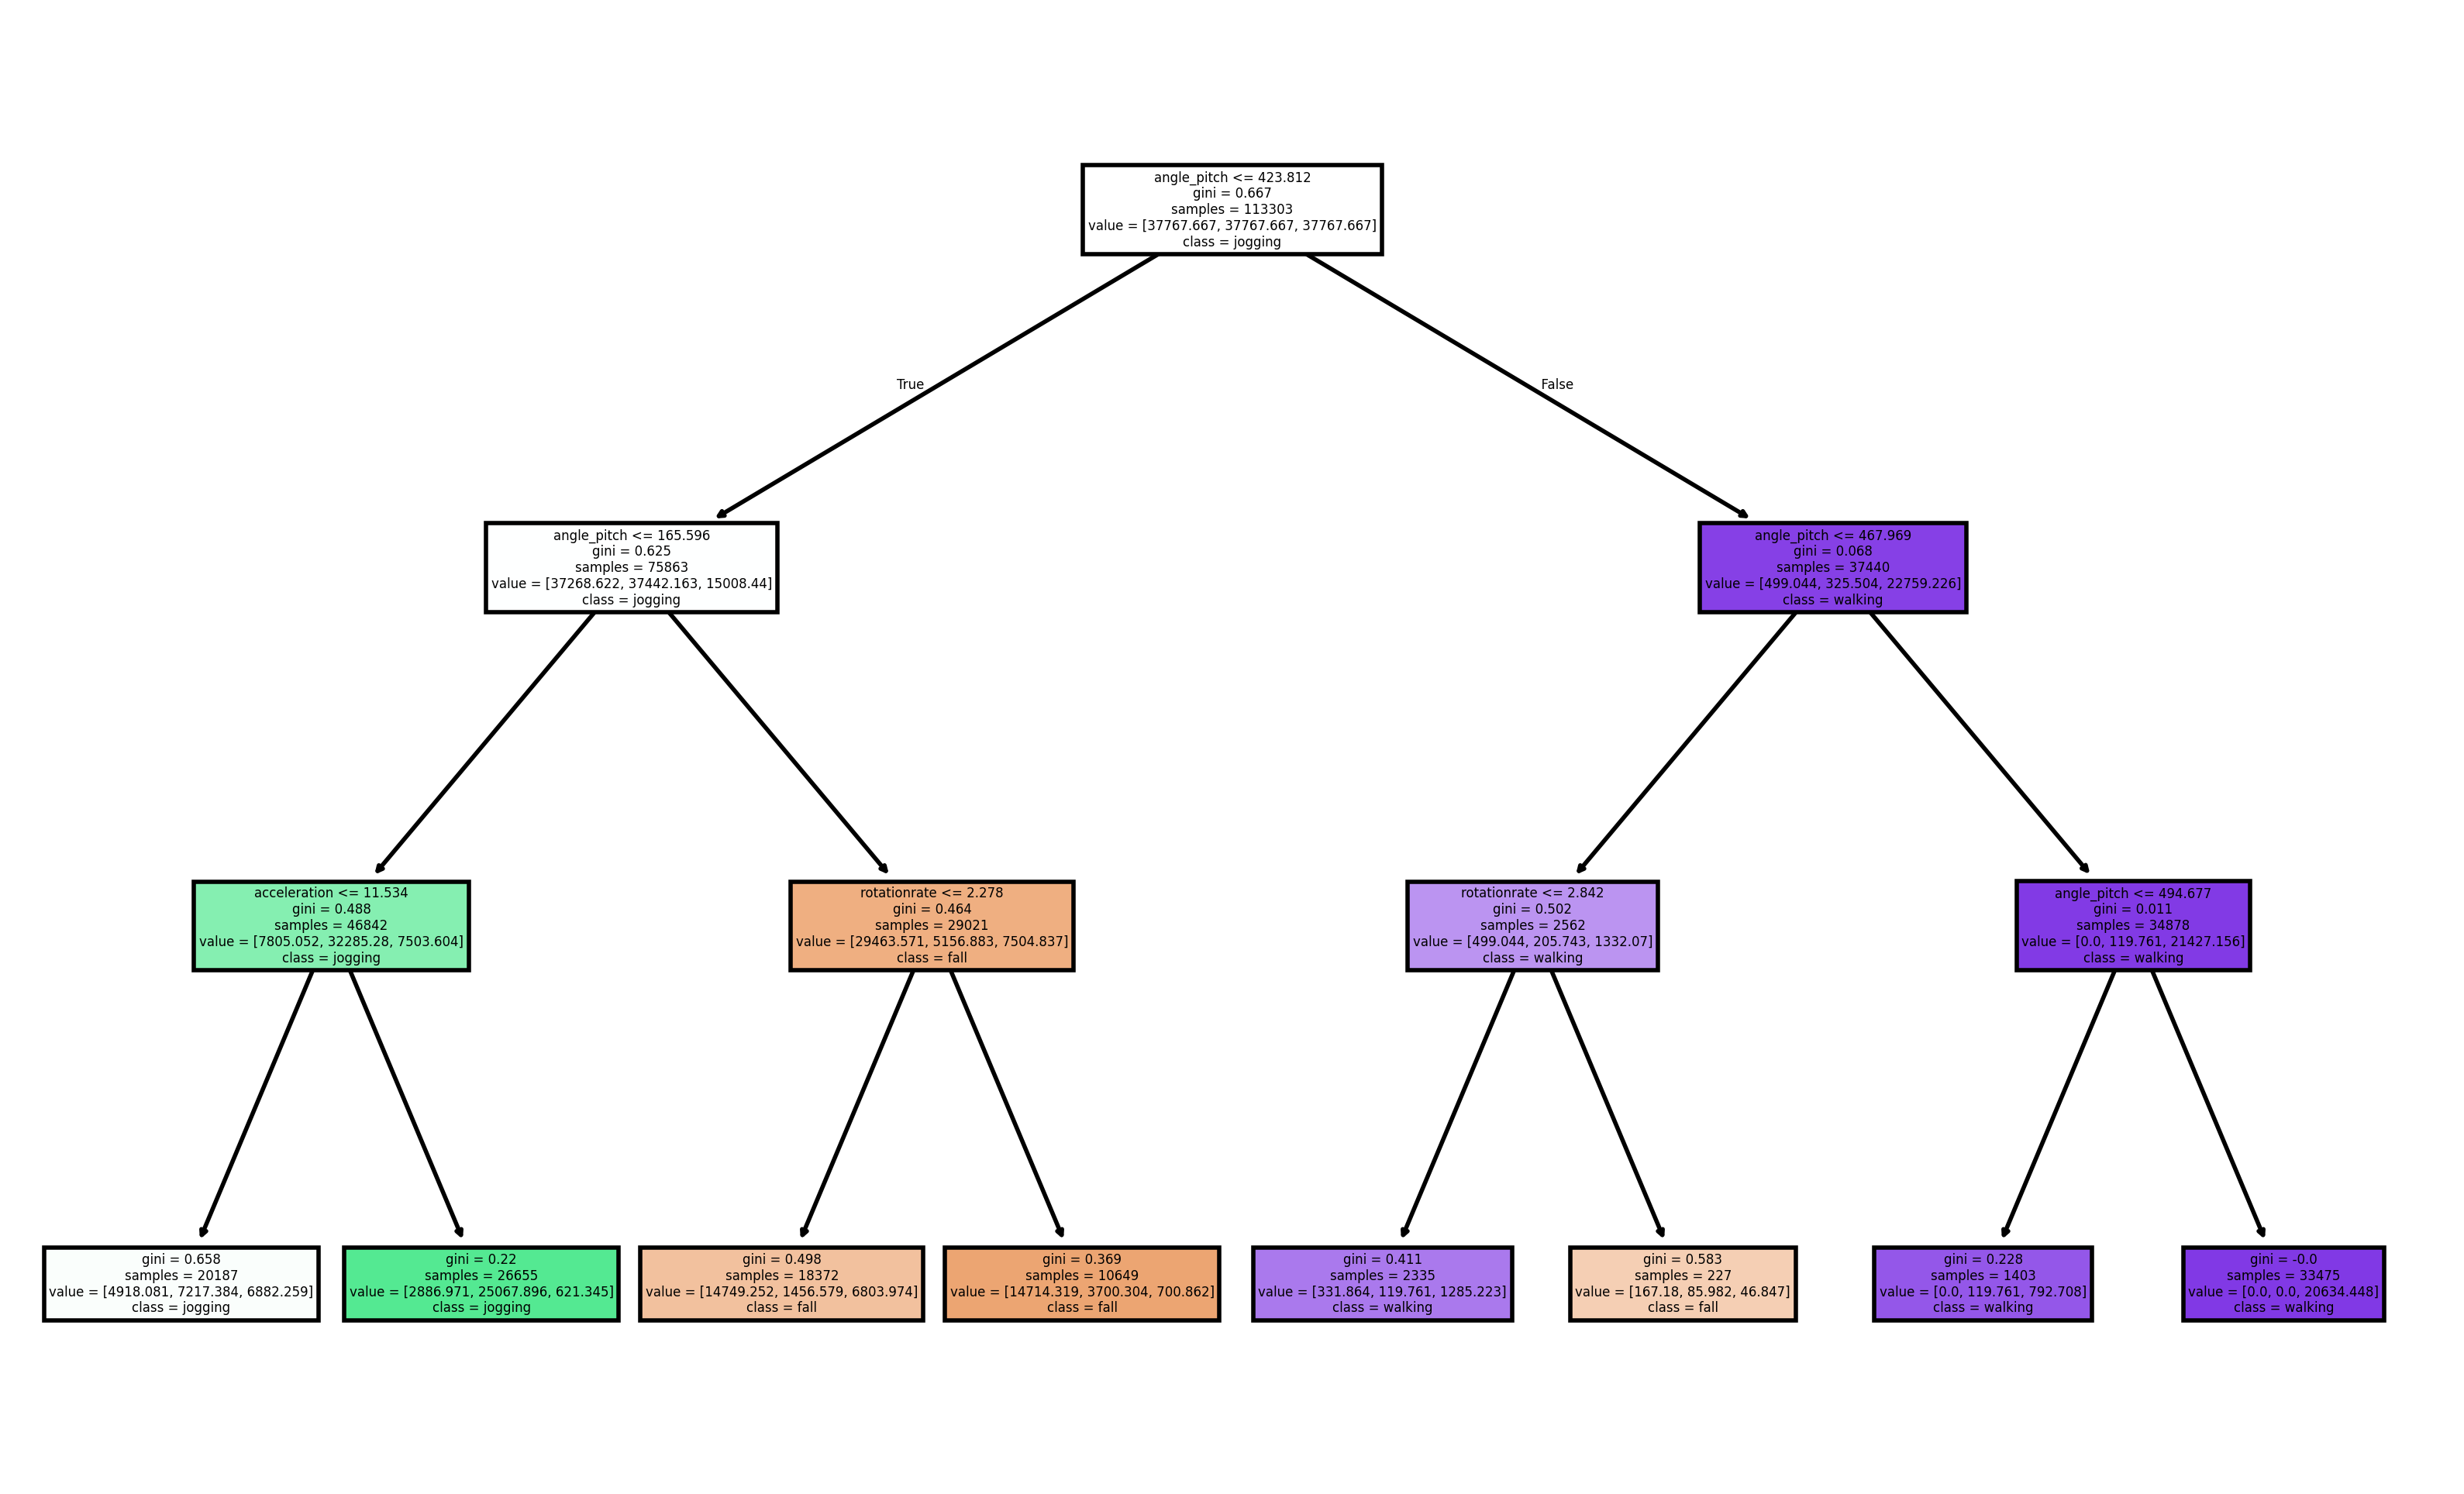

In [11]:
plt.figure(figsize=(10, 6), dpi=400)
plot_tree(clf, feature_names=X.columns, class_names=clf.classes_, filled=True)
plt.show()

In [12]:
# Extract rules
c_features = tree_to_rules(clf, X.columns)
print_rules(c_features)

Rules for class jogging:
  - angle_pitch <= 165.60 and acceleration <= 11.53
  - angle_pitch <= 165.60 and acceleration > 11.53

Rules for class fall:
  - angle_pitch > 165.60 and angle_pitch <= 423.81 and acceleration > 11.53 and rotationrate <= 2.28
  - angle_pitch > 165.60 and angle_pitch <= 423.81 and acceleration > 11.53 and rotationrate > 2.28
  - angle_pitch > 423.81 and angle_pitch <= 467.97 and acceleration > 11.53 and rotationrate > 2.84

Rules for class walking:
  - angle_pitch > 423.81 and angle_pitch <= 467.97 and acceleration > 11.53 and rotationrate > 2.28 and rotationrate <= 2.84
  - angle_pitch > 467.97 and angle_pitch <= 494.68 and acceleration > 11.53 and rotationrate > 2.84
  - angle_pitch > 494.68 and acceleration > 11.53 and rotationrate > 2.84



In [13]:
from sklearn.tree import _tree


def tree_to_code(tree, feature_names=range(0, 28)):
	nspaces = 4
	tree_ = tree.tree_
	feature_name = [
		feature_names[i] if i != _tree.TREE_UNDEFINED else 'undefined!' for i in tree_.feature
	]

	print('float ClassificationTree(floqat* features)')
	print('{')

	def recurse(node, depth):
		indent = ' ' * nspaces * depth

		if tree_.feature[node] != _tree.TREE_UNDEFINED:
			name = feature_name[node]
			threshold = tree_.threshold[node]

			print('\n{}if ({} <= {:0.2f})'.format(indent, name, threshold))
			print('{}'.format(indent) + '{')

			recurse(tree_.children_left[node], depth + 1)

			print('{}'.format(indent) + '}')
			print('{}else'.format(indent) + '\n' + '{}'.format(indent) + '{')

			recurse(tree_.children_right[node], depth + 1)

			print('\n' + '{}'.format(indent) + '}')
		else:
			"""
            Normalize the value of the zero index,
            which contains the number of objects of class 0 to the total number
            of objects that fall into current node.
            
            Example:
                tree_.value[node] returns [[21. 15. 3.]]
                It means that there are 21. object of class 0
                                        15. objects of class 1
                                        3. object of class 2
                                        21. / (21. + 15. + 3) = probability of class 0 in current node
            """
			# Get the array of class counts
			class_counts = tree_.value[node][0]
			# Find the index of the class with the highest count
			predicted_class_index = np.argmax(class_counts)
			class_name = clf.classes_[predicted_class_index]
			print("\n{}return '{}'; // Predicted class index".format(indent, class_name))

			# print("\n{}return {:0.9f};".format(indent, tree_.value[node][0][0] / sum(tree_.value[node][0])))

	recurse(0, 1)

	print('}')


tree_to_code(clf, X.columns)

float ClassificationTree(floqat* features)
{

    if (angle_pitch <= 423.81)
    {

        if (angle_pitch <= 165.60)
        {

            if (acceleration <= 11.53)
            {

                return 'jogging'; // Predicted class index
            }
            else
            {

                return 'jogging'; // Predicted class index

            }
        }
        else
        {

            if (rotationrate <= 2.28)
            {

                return 'fall'; // Predicted class index
            }
            else
            {

                return 'fall'; // Predicted class index

            }

        }
    }
    else
    {

        if (angle_pitch <= 467.97)
        {

            if (rotationrate <= 2.84)
            {

                return 'walking'; // Predicted class index
            }
            else
            {

                return 'fall'; // Predicted class index

            }
        }
        else
        {

            if (angle_pitch <= 494.

In [14]:
df = pd.read_csv('raw_data2.csv')
df = preprocess_df(df)
X = df[['acceleration', 'rotationrate', 'angle_pitch']]
y = df['label']
# print(classification_report(y, clf.predict(X)))
pred_labels = clf.predict(X)
mapped = pd.Series(pred_labels).map(lambda x: 'ADL' if x in ['fall', 'jogging'] else '')

(mapped == y).value_counts()

True     298
False    118
Name: count, dtype: int64

In [20]:
from collections import defaultdict, deque
from sklearn.tree import _tree


def tree_to_code(tree, feature_names=range(0, 28)):
	tree_ = tree.tree_
	feature_name = [
		feature_names[i] if i != _tree.TREE_UNDEFINED else 'undefined!' for i in tree_.feature
	]
	dq = deque()
	f_expr = defaultdict(list)

	def recurse(node, depth, dq):
		name = feature_name[node]
		threshold = f"{tree_.threshold[node]:.2f}"

		if tree_.feature[node] != _tree.TREE_UNDEFINED:
			tup_expression = (name, "<=", threshold)
			dq.append(tup_expression)
			dq.append("AND")
			recurse(tree_.children_left[node], depth + 1, dq)
			dq.pop()
			dq.pop()

			tup_expression = (name, ">", threshold)
			dq.append(tup_expression)
			dq.append("AND")
			recurse(tree_.children_right[node], depth + 1, dq)
			dq.pop()
			dq.pop()
		else:
			# Get the array of class counts
			class_counts = tree_.value[node][0]
			# Find the index of the class with the highest count
			predicted_class_index = np.argmax(class_counts)
			class_name = clf.classes_[predicted_class_index]

			d_copy = dq.copy()
			d_copy.pop()
			f_expr[class_name].append(d_copy)
			return class_name

	recurse(0, 1, dq)
	return f_expr


d = tree_to_code(clf, X.columns)
d

defaultdict(list,
            {'jogging': [deque([('angle_pitch', '<=', '423.81'),
                     'AND',
                     ('angle_pitch', '<=', '165.60'),
                     'AND',
                     ('acceleration', '<=', '11.53')]),
              deque([('angle_pitch', '<=', '423.81'),
                     'AND',
                     ('angle_pitch', '<=', '165.60'),
                     'AND',
                     ('acceleration', '>', '11.53')])],
             'fall': [deque([('angle_pitch', '<=', '423.81'),
                     'AND',
                     ('angle_pitch', '>', '165.60'),
                     'AND',
                     ('rotationrate', '<=', '2.28')]),
              deque([('angle_pitch', '<=', '423.81'),
                     'AND',
                     ('angle_pitch', '>', '165.60'),
                     'AND',
                     ('rotationrate', '>', '2.28')]),
              deque([('angle_pitch', '>', '423.81'),
                     'AND',
       

In [18]:
def get_expressions(feature):
    l = []
    for dq in d[feature]:
        final_exp = []
        for dd in dq:
            if isinstance(dd, tuple):
                final_exp.append(f"{dd[0]} {dd[1]} {dd[2]}")
            else:
                match dd:
                    case "AND":
                        final_exp.append("&&")
                    case "OR":
                        final_exp.append("||")
                    case _:
                        final_exp.append(dd)
        l.append(" ".join(final_exp))
    return "\n".join(l)

In [19]:
for class_name in clf.classes_:
    print(class_name)
    print(get_expressions(class_name))
    print()

fall
angle_pitch <= 423.81 && angle_pitch > 165.60 && rotationrate <= 2.28
angle_pitch <= 423.81 && angle_pitch > 165.60 && rotationrate > 2.28
angle_pitch > 423.81 && angle_pitch <= 467.97 && rotationrate > 2.84

jogging
angle_pitch <= 423.81 && angle_pitch <= 165.60 && acceleration <= 11.53
angle_pitch <= 423.81 && angle_pitch <= 165.60 && acceleration > 11.53

walking
angle_pitch > 423.81 && angle_pitch <= 467.97 && rotationrate <= 2.84
angle_pitch > 423.81 && angle_pitch > 467.97 && angle_pitch <= 494.68
angle_pitch > 423.81 && angle_pitch > 467.97 && angle_pitch > 494.68

